In [1]:
import sys
import os
import os.path as op
# from dipy.io.image import load_nifti
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchio as tio
import numpy as np
# import pytorch_lightning as pl
import pandas as pd
import seaborn as sns
import re
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [2]:
data_path = op.join(sys.path[0], '../../Experiment4/sub-01/mfmri.nii.gz')

In [51]:
img = tio.ScalarImage(data_path)
img

ScalarImage(shape: (360, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment4/sub-01/mfmri.nii.gz")

In [57]:
transform1 = tio.CropOrPad((160, 64, 35))
img = transform1(img.data[0][None,:])

In [74]:
x_tensor = img.reshape(1,160,-1).to(DEVICE).unsqueeze(0)
pr_mask = created_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round()).reshape(160,64,35)

In [91]:
new_mask = tio.ScalarImage(data_path)
new_mask.set_data(pr_mask[None,:])
new_mask.save('test.nii.gz')

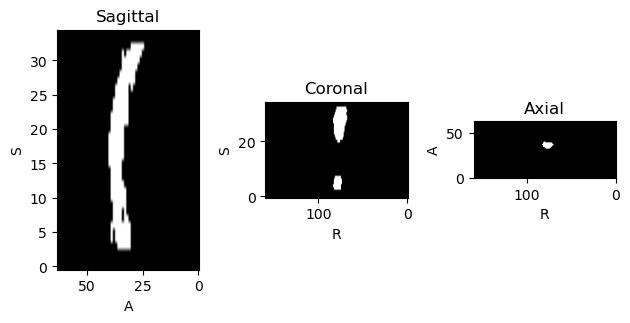

In [100]:
tio.ScalarImage('test.nii.gz').plot()

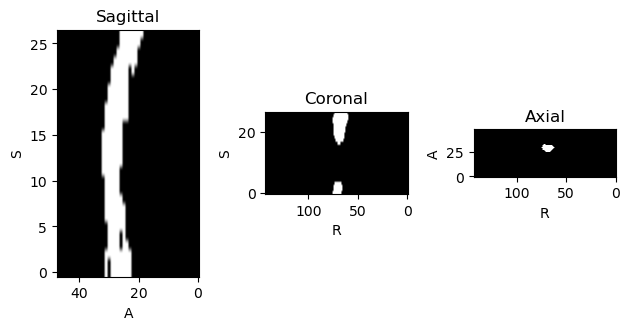

In [101]:
tio.ScalarImage('test2.nii.gz').plot()

In [94]:
tio.ScalarImage(data_path).shape

(360, 144, 48, 27)

In [95]:
reverse_trans = tio.CropOrPad((144, 48, 27))

In [98]:
new_mask = reverse_trans(new_mask)
new_mask.save('test2.nii.gz')

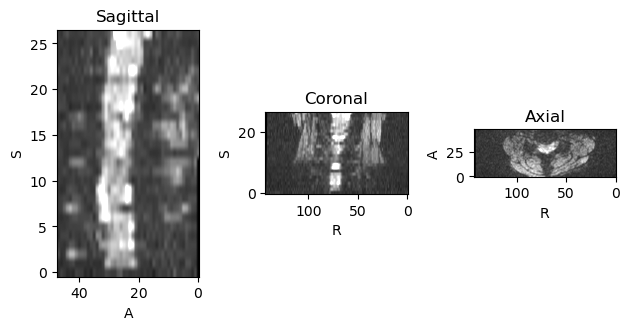

In [4]:
img.plot()

In [59]:
img.shape

torch.Size([1, 160, 64, 35])

In [5]:
label_path = op.join(sys.path[0], '../../Experiment4/sub-01/mask_sc.nii.gz')

In [6]:
label = tio.LabelMap(label_path)
label

LabelMap(shape: (1, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment4/sub-01/mask_sc.nii.gz")

In [83]:
tio.ScalarImage(data_path).affine

array([[ -0.97222221,   0.        ,   0.        ,  70.00000763],
       [  0.        ,   0.91711758,   0.99564561, -54.52362823],
       [  0.        ,  -0.32266294,   2.82996287, -35.62229919],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [82]:
label.affine

array([[ -0.97222221,   0.        ,   0.        ,  70.00105286],
       [  0.        ,   0.91711758,   0.99564561, -54.52362823],
       [  0.        ,  -0.32266294,   2.82996287, -35.62229919],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

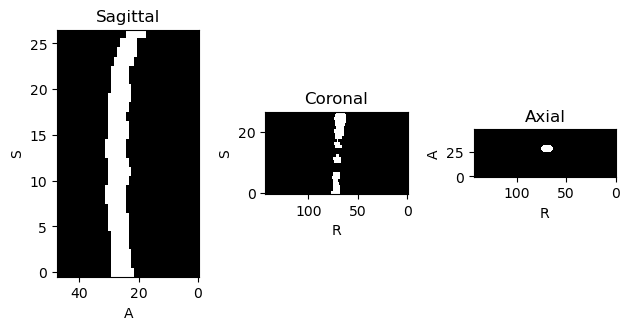

In [7]:
label.plot()

In [8]:
motion_param = {}
for i in range(1, 20):
    motion_param[f'sub{i}'] = pd.read_csv(f'../../Experiment4/sub-{i:02d}/motion_xy.txt', sep=" ", names=['x', 'y', 'remove'])[['x', 'y']]
    motion_param[f'sub{i}']['Volume'] = range(1,361)
    motion_param[f'sub{i}']['subject'] = f'sub{i}'
    
motion_param[f'sub21'] = pd.read_csv(f'../../Experiment4/sub-21/motion_xy.txt', sep=" ", names=['x', 'y', 'remove'])[['x', 'y']]

for i in motion_param.keys():
    motion_param[i]['Volume'] = range(1,361)
    motion_param[i]['subject'] = i

In [9]:
overall = pd.concat(motion_param.values())
overall

,x,y,Volume,subject
0,0.000000,0.000000,1,sub1
1,0.048104,0.133932,2,sub1
2,0.046358,0.186349,3,sub1
3,0.065004,0.247594,4,sub1
4,0.046905,0.077291,5,sub1
...,...,...,...,...
355,0.417137,0.879837,356,sub21
356,0.463591,0.582148,357,sub21
357,0.441066,0.778352,358,sub21
358,0.384013,0.891708,359,sub21


[Text(0.5, 0, 'subjects'),
 Text(0, 0.5, 'motion in y direction'),
 Text(0.5, 1.0, 'Motion in Y Direction')]

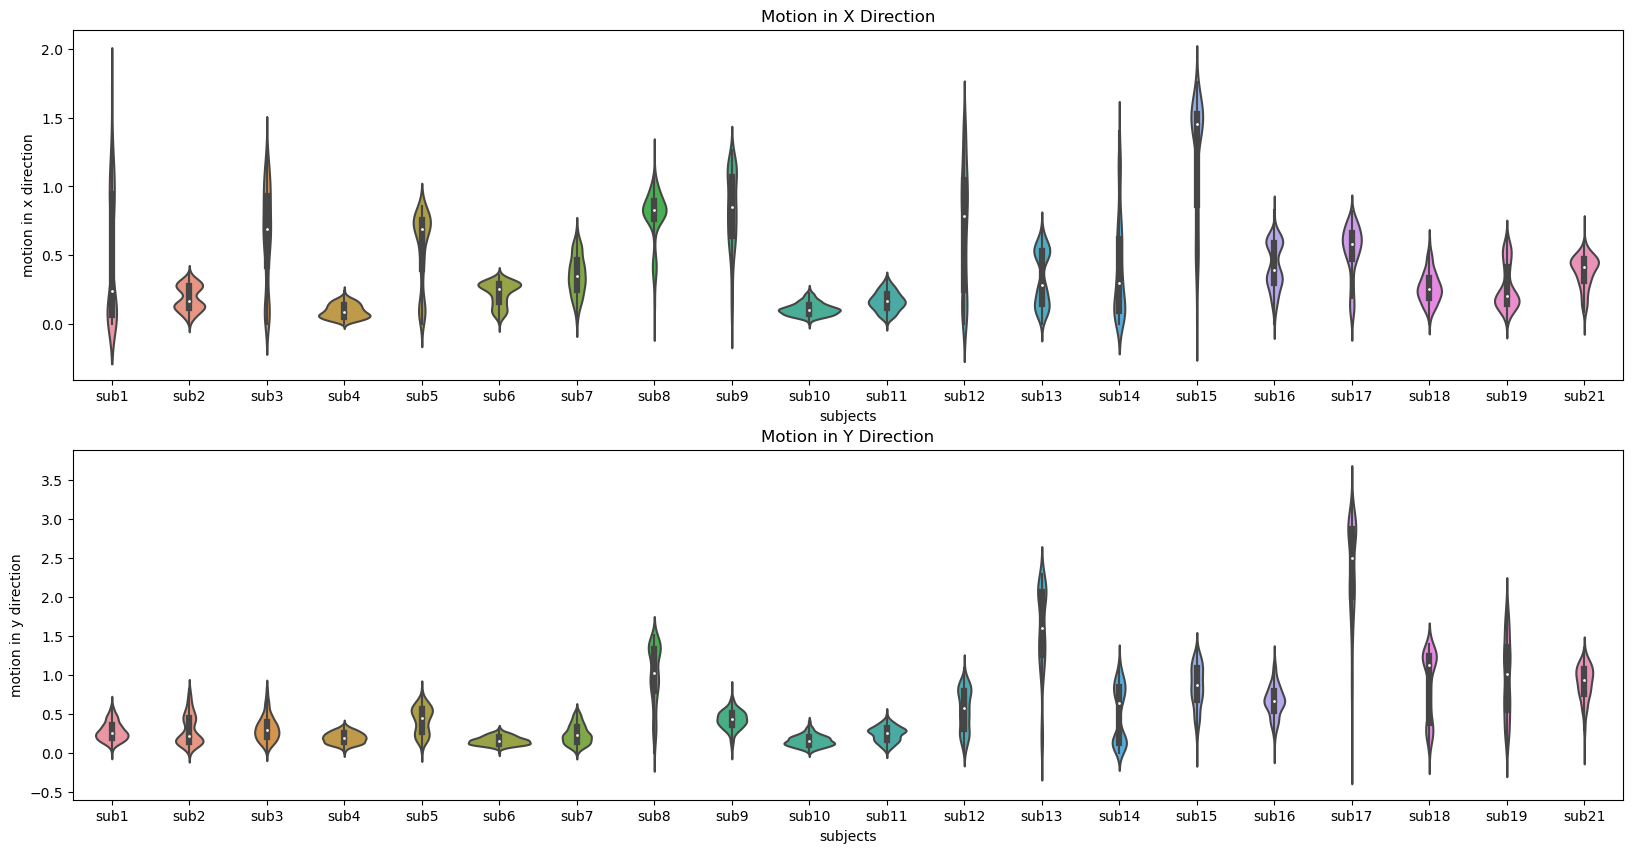

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
gx = sns.violinplot(data=overall, x='subject', y='x', ax=ax[0])
gx.set(xlabel='subjects', ylabel='motion in x direction', title='Motion in X Direction')

gy = sns.violinplot(data=overall, x='subject', y='y', ax=ax[1])
gy.set(xlabel='subjects', ylabel='motion in y direction', title='Motion in Y Direction')

[Text(0.5, 0, 'subjects'),
 Text(0, 0.5, 'motion in y direction'),
 Text(0.5, 1.0, 'Motion in Y Direction')]

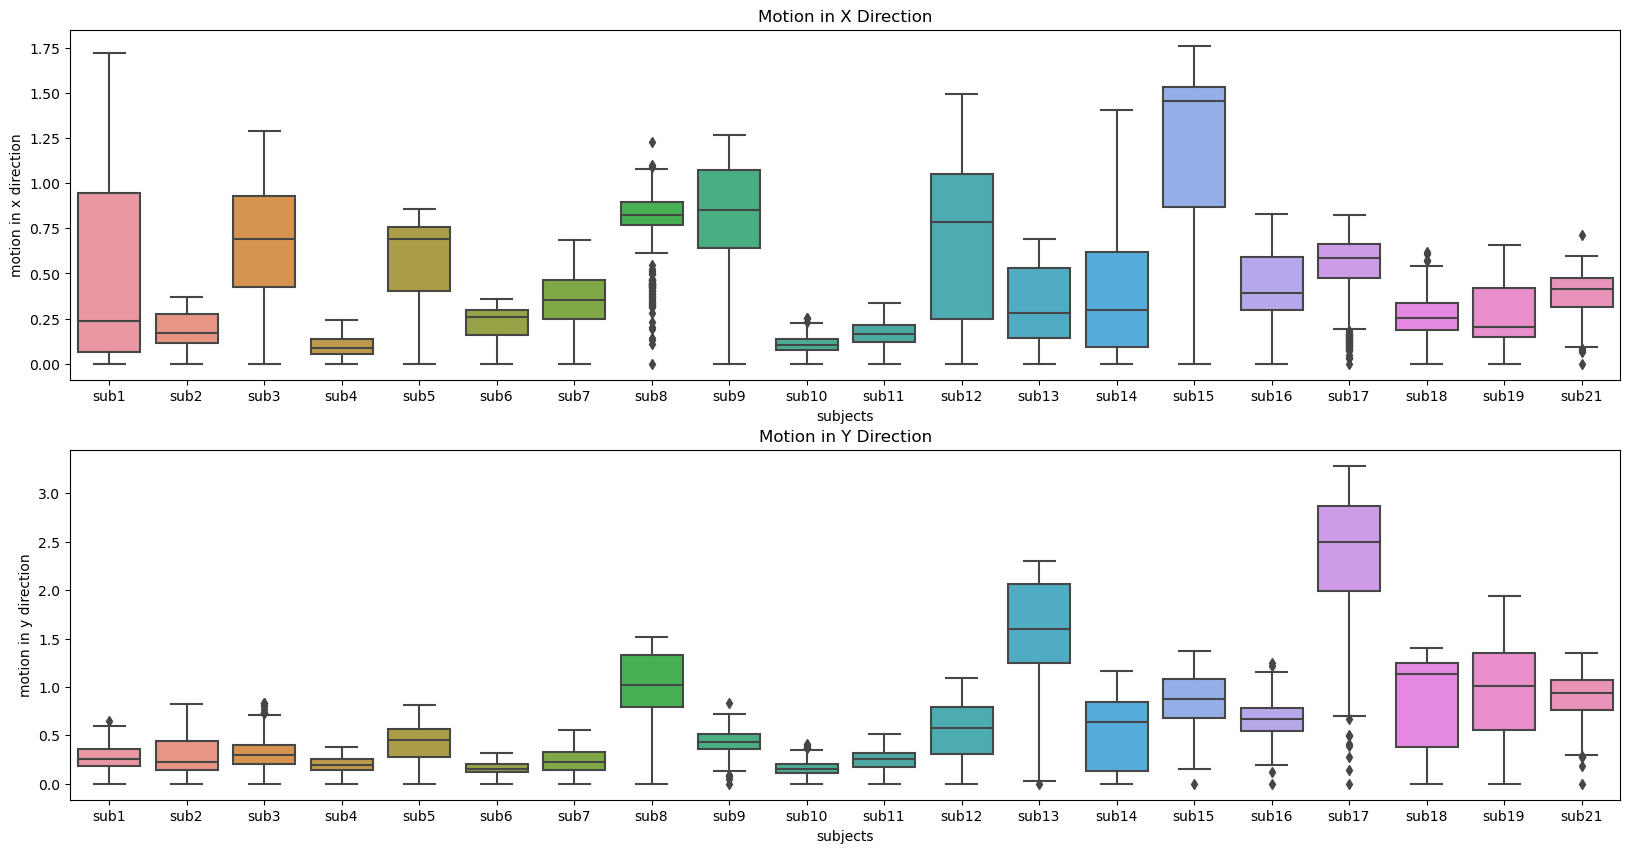

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
gx = sns.boxplot(data=overall, x='subject', y='x', ax=ax[0])
gx.set(xlabel='subjects', ylabel='motion in x direction', title='Motion in X Direction')

gy = sns.boxplot(data=overall, x='subject', y='y', ax=ax[1])
gy.set(xlabel='subjects', ylabel='motion in y direction', title='Motion in Y Direction')

Subjects with largest amplitude are: sub1, sub3, sub5, sub7, sub8, sub9, sub12, sub13, sub14, sub15, sub16, sub17, sub18, sub19, sub21

This leaves us with: sub2, sub4, sub6, sub10, sub11

In [12]:
mask = overall['subject'].isin(['sub2', 'sub4', 'sub6', 'sub10', 'sub11'])
filtered_overall = overall[mask]

Now calculating framewise displacement

In [13]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]
    trans_params = framewise_diff[['x', 'y']]
    fd = trans_params.abs().sum(axis=1)
    return fd

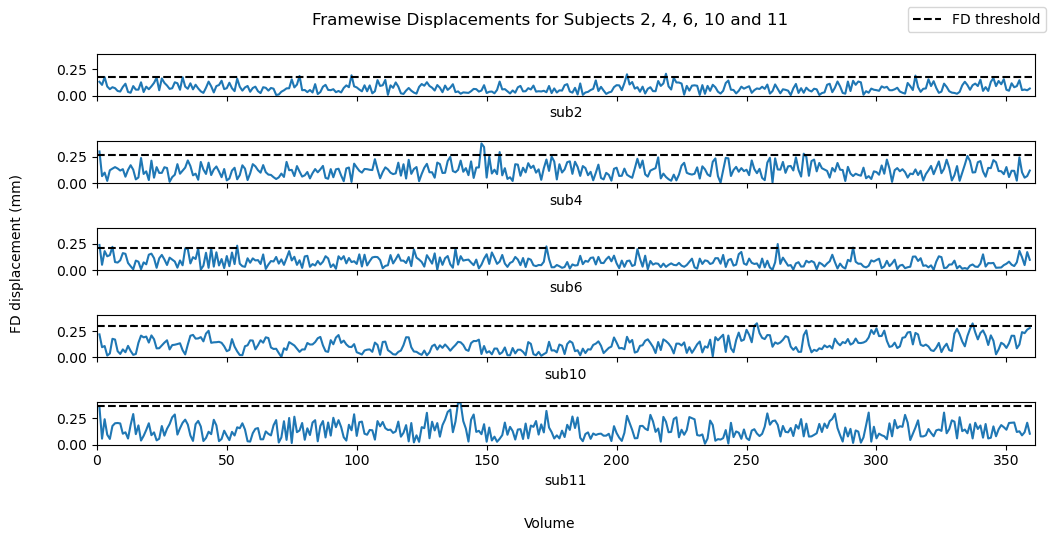

In [14]:
fig, ax = plt.subplots(filtered_overall['subject'].nunique(), 1, figsize=(10, 5), sharex=True)

for index, key in enumerate(filtered_overall['subject'].unique()):
    fd = compute_FD_power(filtered_overall[filtered_overall['subject'].isin([key])][['x', 'y']]).to_numpy()
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    ax[index].plot(list(range(1, fd.size+1)), fd, label='_nolegend_')
    ax[index].set_xlim(left=0, right=361)
    ax[index].set_ylim(bottom=0, top=0.4)
    ax[index].hlines(threshold, 0, 360,colors='black', linestyles='dashed', label='FD threshold')
    ax[index].set_xlabel(key)

fig.text(0.5, -0.05, 'Volume', ha='center', rotation='horizontal')
fig.suptitle('Framewise Displacements for Subjects 2, 4, 6, 10 and 11')
fig.text(-0.04, 0.5, 'FD displacement (mm)', va='center', rotation='vertical')
fig.legend(['FD threshold'])
plt.tight_layout()

Maybe plotting the distribution of framewise displacements would be a more accurate solution. The chosen approach is however good enough.

In [15]:
for index, key in enumerate(filtered_overall['subject'].unique()):
    fd = compute_FD_power(filtered_overall[filtered_overall['subject'].isin([key])][['x', 'y']]).to_numpy()
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    print(f'Motion Outliers for {key}:', np.where(fd > threshold)[0] + 1)
    print(f'Threshold for {key}: {threshold}')

Motion Outliers for sub2: [ 78  98 204 219 315]
Threshold for sub2: 0.17990999999999996
Motion Outliers for sub4: [  1 148 149 155 272]
Threshold for sub4: 0.26348375
Motion Outliers for sub6: [  1   6  54 173 262 291]
Threshold for sub6: 0.20878175000000002
Motion Outliers for sub10: [253 254 337]
Threshold for sub10: 0.29768675
Motion Outliers for sub11: [139 140]
Threshold for sub11: 0.3631835


Subject 2 will be chosen as the threshold is much lower. Setting the treshold to the one of subject 6 which is the second smallest, results in no 'outlier'.
We have a framewise displacement of 0.073562 +/- 0.039928 mm.

In [16]:
sub2_fd = compute_FD_power(filtered_overall[filtered_overall['subject'].isin(['sub2'])][['x', 'y']])
sub2_fd.describe()

count    359.000000
mean       0.073562
std        0.039928
min        0.006552
25%        0.043205
50%        0.067982
75%        0.097887
max        0.208611
dtype: float64

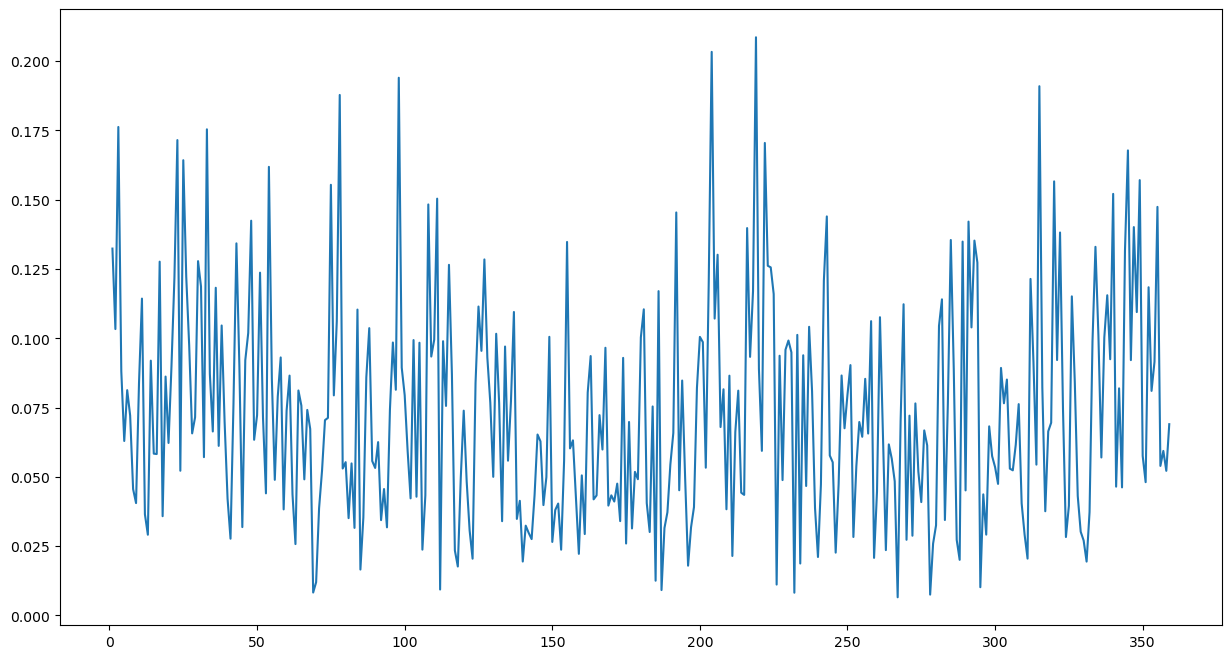

In [17]:
plt.figure(figsize=(15,8))
plt.plot(list(range(1, fd.size+1)), sub2_fd)

In [18]:
np.where(sub2_fd > 0.175)[0]

array([  2,  32,  77,  97, 203, 218, 314])

[Text(0.5, 0, 'subjects'),
 Text(0, 0.5, 'motion in y direction'),
 Text(0.5, 1.0, 'Motion in Y Direction')]

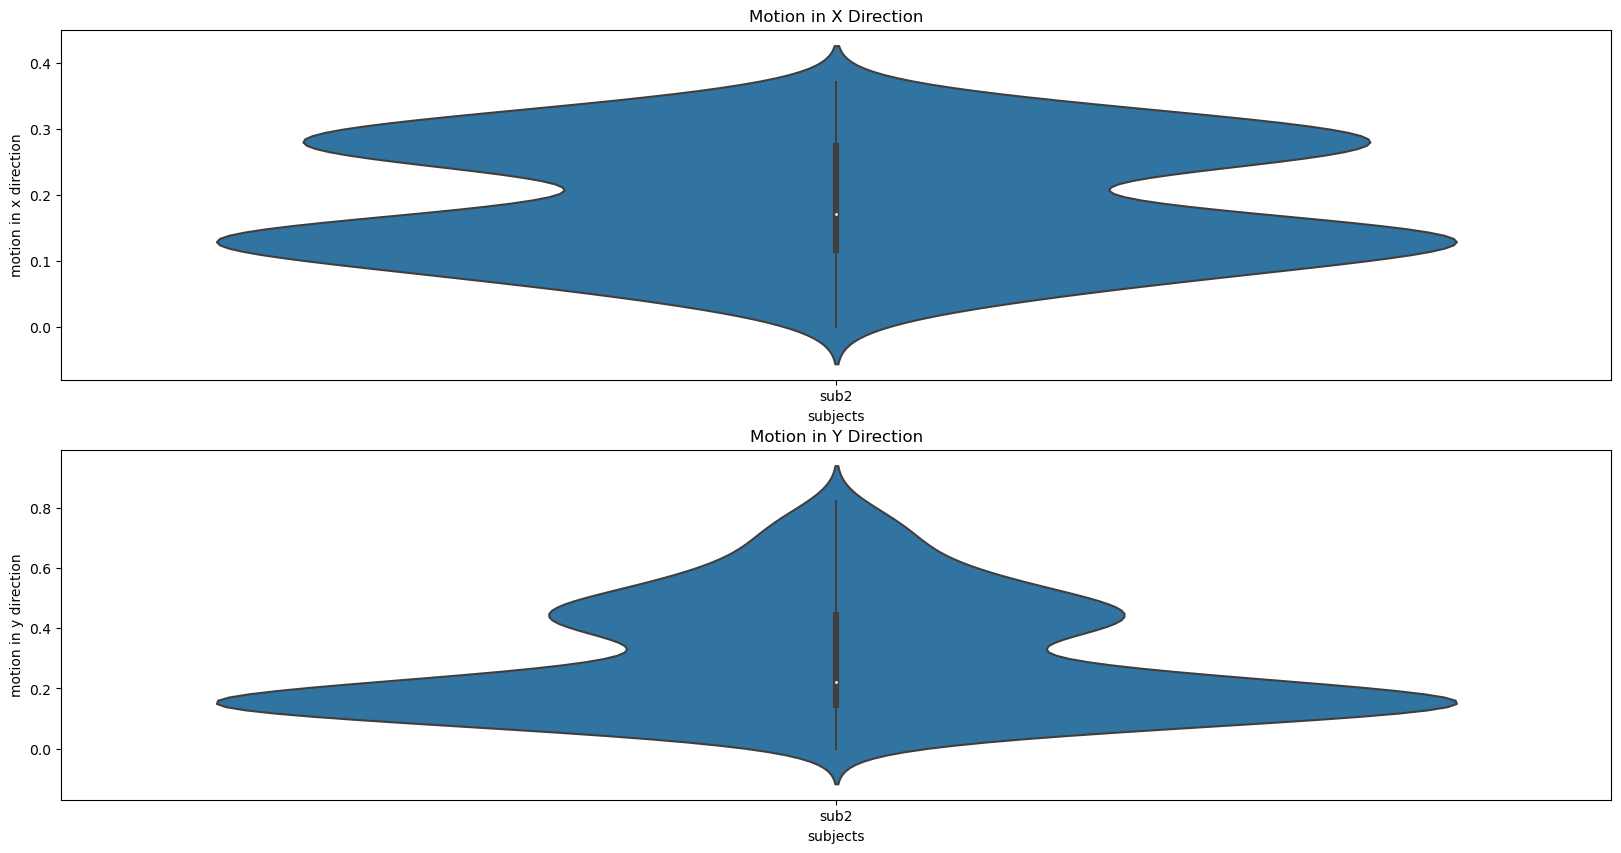

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
gx = sns.violinplot(data=filtered_overall[filtered_overall['subject'].isin(['sub2'])], x='subject', y='x', ax=ax[0])
gy = sns.violinplot(data=filtered_overall[filtered_overall['subject'].isin(['sub2'])], x='subject', y='y', ax=ax[1])
gx.set(xlabel='subjects', ylabel='motion in x direction', title='Motion in X Direction')
gy.set(xlabel='subjects', ylabel='motion in y direction', title='Motion in Y Direction')

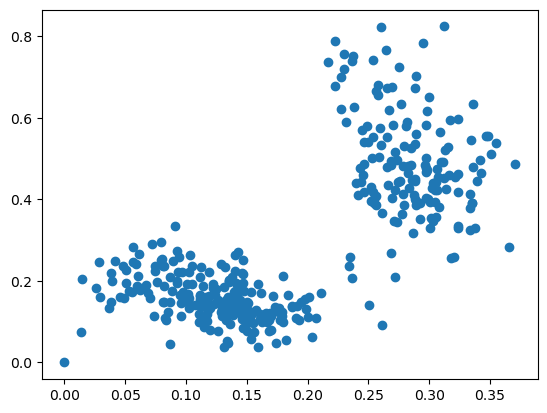

In [20]:
plt.scatter(filtered_overall[filtered_overall['subject'].isin(['sub2'])]['x'], filtered_overall[filtered_overall['subject'].isin(['sub2'])]['y'])

## Subject 2 prediction with SOTA model

### Splitting 4D sequence into 3D images

In [21]:
sub2 = op.join(sys.path[0], '../../Experiment4/sub-02/mfmri.nii.gz')

In [22]:
fmri_seq = tio.ScalarImage(sub2)

In [23]:
img_data = {}
for fmri_idx in range(fmri_seq.shape[0]):
    img_data[f'img{fmri_idx}'] = tio.ScalarImage(sub2)
    img_data[f'img{fmri_idx}'].set_data(fmri_seq.data[fmri_idx, :, :, :][None, :])
    img_data[f'img{fmri_idx}'].save(f'../../Experiment4/sub-02/single_images/fmri-{fmri_idx}.nii.gz')

In [24]:
from torch.utils.data import Dataset

class SpinalCordDataset(Dataset):
    def __init__(self, annotations_files, img_files, transform=None, target_transform=None):
        self.img_labels = annotations_files
        self.img_files = img_files
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        image = img_file.data
        label = self.img_labels[idx].data
        if self.transform:
            image = self.transform(image).reshape(1,160,-1)
        if self.target_transform:
            label = self.target_transform(label).reshape(1,160,-1)
        return image, label

In [25]:
image_files = []
image_labels = []

single_imgs = Path(op.join(sys.path[0], '../../Experiment4/sub-02/single_images'))

for file in single_imgs.iterdir():
    image_files.append(tio.ScalarImage(file))

# get index of the fmri volume and add the corresponding mask in the same order
regex = re.compile(r'\d+')
for img in image_files:
    idx = [int(x) for x in regex.findall(str(img.path))][2]
    if idx in [0, 2, 3, 225]:
        label_path = op.join(sys.path[0], f'../../Experiment4/sub-02/mask_sc_vol{idx}.nii.gz')
    else:
        label_path = op.join(sys.path[0], '../../Experiment4/sub-02/mask_sc.nii.gz')
    image_labels.append(tio.ScalarImage(label_path))

In [26]:
dataset = SpinalCordDataset(image_labels, image_files, tio.CropOrPad((160, 64, 35)), tio.CropOrPad((160, 64, 35)))

Load the trained model

In [27]:
import segmentation_models_pytorch.utils as smpu

In [28]:
test_loader = DataLoader(dataset, batch_size=16, shuffle=True)
loss = smpu.losses.DiceLoss()
metrics = [
    smpu.metrics.IoU(threshold=0.5),
]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
created_model = torch.load('../../output3/k_cross.pth')

In [150]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 23/23 [08:51<00:00, 23.09s/it, dice_loss - 0.09877, iou_score - 0


In [65]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(np.swapaxes(image, 0, 1))
    plt.show()

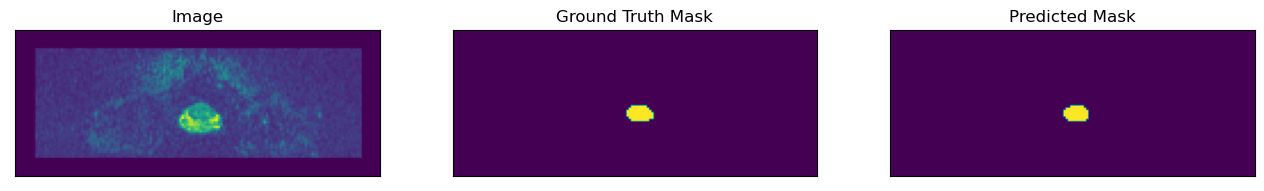

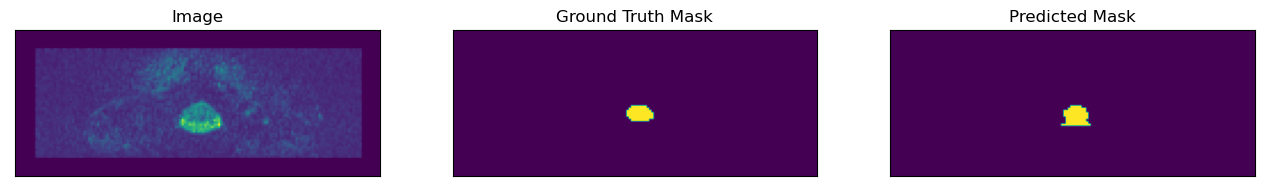

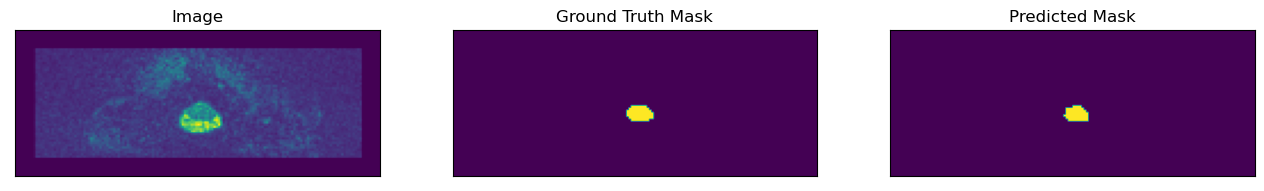

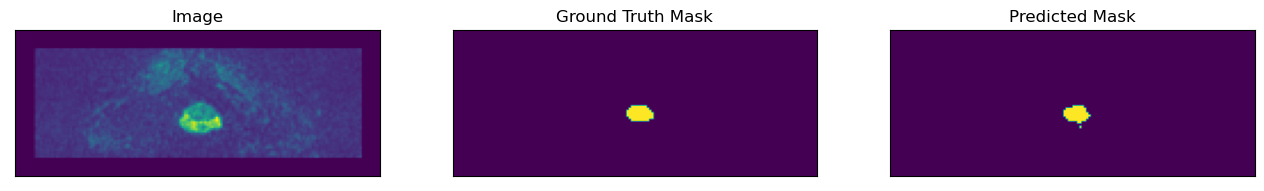

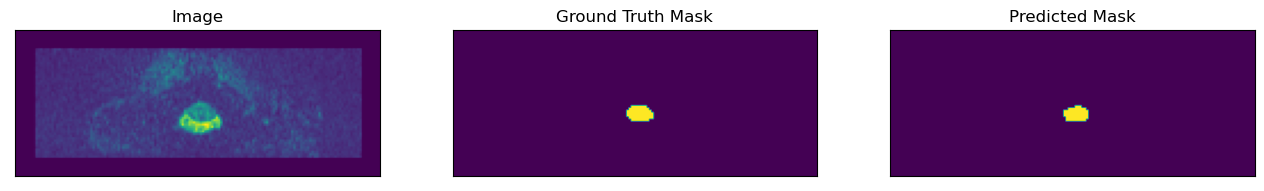

In [78]:
for i in range(5):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(160, 64, 35)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(160,64,35)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = created_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round()).reshape(160,64,35)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [159]:
1-logs['dice_loss']

0.9012278914451599

In [160]:
logs

{'dice_loss': 0.0987721085548401, 'iou_score': 0.8229122213695359}

## Augmentation

New split of data needed to have test and training data

## FSLeyes

In [9]:
load('../../Experiment4/sub-01/mfmri.nii.gz')

Image(mfmri, /home/tim/OneDrive/Studium M. Sc/EPFL/Project/Experiment4/sub-01/mfmri.nii.gz)

In [10]:
load('../../Experiment4/sub-01/mask_sc.nii.gz')

Image(mask_sc, /home/tim/OneDrive/Studium M. Sc/EPFL/Project/Experiment4/sub-01/mask_sc.nii.gz)